## Description

Paper: Kendall & Gal: "What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?" (2017)[link](https://arxiv.org/abs/1703.04977)

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

import tqdm
from matplotlib.gridspec import GridSpec
from functools import partial




In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [3]:
train_set = dset.MNIST(root="data/", train=True, transform=tt.ToTensor(), download=True)
test_set = dset.MNIST(root="data/", train=False, transform=tt.ToTensor(), download=True)

**Model description**
The classification model is trained to predict the mean $f_i$ and variance $\sigma_i$ of the classification logits $\hat{x_i}$ such that 

$$
\hat{x}_{i, t} = f_i + \sigma_i\epsilon_t \quad \epsilon_t\sim\mathcal{N}(0, 1)
$$


**Loss function** 
$$
\mathcal{L} = \sum_i\log\frac{1}{T}\sum_t\exp(\hat{x}_{i, t, c} - \log\sum_{c^\prime}\exp\hat{x}_{i, t, c})
$$

Softmax of true class $c$ averaged over $T$ random logit samples summed over elements in batch.

In [4]:
def aleatoric_loss(predictions, labels):
    '''
    calculate the loss function for the prediction aleatoric uncertainty in classifictaion 
    as describend in (Kendall & Gal, 2017). 

    predictions ...  random samples of the logits, dim = batch_size x n_classes x n_samples
    labels ... integer vector of true labels, dim = batch_size x 1
    '''
    # select the logit corresponding to the true class label 
    true_labels = predictions[range(predictions.shape[0]), labels, :]
    
    #sum over exp of all logits 
    class_sum = torch.exp(predictions).sum(axis=1)

    # average softmax over all samples
    sample_mean = torch.exp(true_labels - torch.log(class_sum)).mean(axis=1)

    # sum over batch 
    batch_mean = torch.log(sample_mean).mean()
    
    # loss function aims to maximize softmax, needs to be inverted
    return (-1)*batch_mean 

In [5]:
class MNIST_model_aleatoric(nn.Module):

  def __init__(self, in_size=784, hidden1=200, hidden2=80, out_size=10, device="cpu"):
    super(MNIST_model_aleatoric, self).__init__()

    self.linear1 = torch.nn.Linear(in_features=in_size, out_features=hidden1, bias=True)
    self.linear2 = torch.nn.Linear(in_features=hidden1, out_features=hidden2, bias=True)
    self.linear_mean = torch.nn.Linear(in_features=hidden2, out_features=out_size, bias=True)
    self.linear_log_var = torch.nn.Linear(in_features=hidden2, out_features=out_size, bias=True)
    self.link = nn.Tanh()
    self.device = device

  def forward(self, x):
    # a forward pass generates a random sample of the logits. 
    # For prediction purposes softmax needs to be applied afterwards 
      
    x = x.view(x.size(0), -1) # transform inputsize (batch_size, 1, height, width) to (batch_size, height*width)
    y = self.link(self.linear1(x))
    y = self.link(self.linear2(y))

    mean = self.linear_mean(y) # dim = batch_size x n_classes
    log_var = self.linear_log_var(y) # elementwise log variance,  dim = batch_size x n_classes
    var = torch.exp(log_var)

    rand = torch.randn_like(mean, device=self.device)
    pred = mean + var*rand # elementwise multiplication of variance with random number
    return pred

  def sample(self, x, n_sample):
    # same as forward but generates multiple random samples
      
    x = x.view(x.size(0), -1) # transform inputsize (batch_size, 1, height, width) to (batch_size, height*width)
    y = self.link(self.linear1(x))
    y = self.link(self.linear2(y))

    mean = self.linear_mean(y).unsqueeze(2) # dim = batch_size x n_classes x n_samples
    log_var = self.linear_log_var(y).unsqueeze(2)  # dim = batch_size x n_classes x n_samples
    var = torch.exp(log_var)
      
    rand = torch.randn(size=[mean.size()[0], mean.size()[1], n_sample], device=self.device)
    pred = mean + var*rand # elementwise multiplication of variance with random number
    return pred

  def mean_var(self, x):
    # outputs the estimated mean and variance for a given input (i.e. no sampling!)
      
    x = x.view(x.size(0), -1) # transform inputsize (batch_size, 1, height, width) to (batch_size, height*width)
    y = self.link(self.linear1(x))
    y = self.link(self.linear2(y))

    mean = self.linear_mean(y) # dim = batch_size x n_classes
    log_var = self.linear_log_var(y) # dim = batch_size x n_classes
    var = torch.exp(log_var)
    return mean, var

In [6]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))
    

def evaluate_aleatoric(epoch, eval_model, val_dl, loss_function, device, verbose=True):
# function for evaluating the validation loss after each training epoch  

  acc = []
  loss = []
  for batch in val_dl:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    preds = eval_model.sample(images, 11)

    acc.append(accuracy(eval_model(images), labels).detach().cpu().numpy())
    loss.append(loss_function(preds, labels).detach().cpu().numpy())
  if verbose: 
      print(f"EPOCH: {epoch}, average validation loss: {np.mean(loss):.2f}, average validation accuracy: {np.mean(acc):.2f}")


In [7]:
val_size = 5000
train_size = len(train_set) - val_size
train_set, val_set = random_split(train_set, [train_size, val_size])

batch_size = 100
train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_set, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_set, 1, num_workers=4, pin_memory=True, shuffle=True)

In [8]:
EPOCHS = 10
LOSS_FUNCTION = aleatoric_loss
LR = 0.01

model = MNIST_model_aleatoric().to(DEVICE)
OPTIMIZER =  torch.optim.SGD(model.parameters(), LR) 
loss_array = []

for epoch in range(EPOCHS):

    for batch in train_dl:
      images, labels = batch
      prediction = model.sample(images.to(DEVICE), n_sample=11)
      loss = LOSS_FUNCTION(prediction, labels.to(DEVICE))
      loss_array.append(loss.detach().cpu().numpy())
      loss.backward() # calculates gradients

      OPTIMIZER.step()
      OPTIMIZER.zero_grad()
    evaluate_aleatoric(epoch, model.eval(), val_dl, LOSS_FUNCTION, DEVICE)
    

EPOCH: 0, average validation loss: 1.28, average validation accuracy: 0.38
EPOCH: 1, average validation loss: 0.88, average validation accuracy: 0.57
EPOCH: 2, average validation loss: 0.58, average validation accuracy: 0.79
EPOCH: 3, average validation loss: 0.46, average validation accuracy: 0.86
EPOCH: 4, average validation loss: 0.40, average validation accuracy: 0.88
EPOCH: 5, average validation loss: 0.36, average validation accuracy: 0.90
EPOCH: 6, average validation loss: 0.34, average validation accuracy: 0.90
EPOCH: 7, average validation loss: 0.33, average validation accuracy: 0.90
EPOCH: 8, average validation loss: 0.31, average validation accuracy: 0.91
EPOCH: 9, average validation loss: 0.30, average validation accuracy: 0.91


## Visualize Prediction

In [9]:
batch = next(iter(test_dl))
IMG, LABEL = batch
DEVICE = "cpu"
model = model.to(DEVICE)

predictions = model.sample(IMG, 100) # logits
predictions = nn.functional.softmax(predictions, dim=1) # class probabilities
predictions = predictions.squeeze().detach().cpu().numpy()

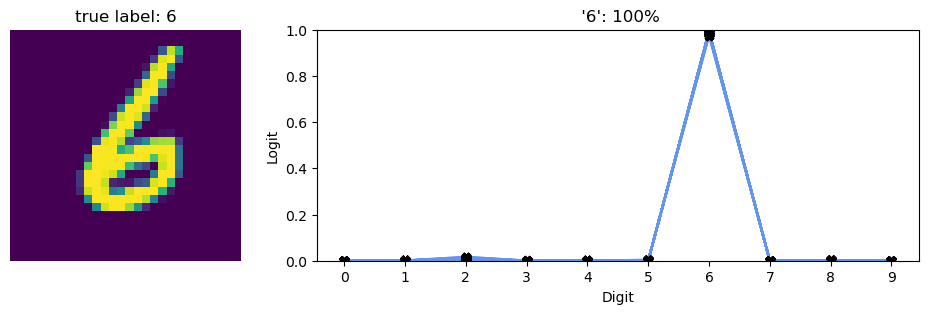

In [10]:
fig = plt.figure(figsize=(12,3))
gs = GridSpec(1, 3)

fig.add_subplot(gs[0])
plt.imshow(IMG.squeeze())
plt.title(f"true label: {LABEL.item()}")
plt.axis("off")

fig.add_subplot(gs[1:])
plt.plot(range(0,10), predictions, color="cornflowerblue", zorder=0)
for xe, ye in zip(range(0,10), predictions):
    plt.scatter([xe] * len(ye), ye, color="k", marker="X")
unique, counts = np.unique(np.argmax(predictions, axis=0), return_counts=True)
plt.title(' '.join(f" '{u}': {round(100*c/predictions.shape[1])}%" for u,c in zip(unique, counts)))
plt.xticks(range(0,10))
plt.xlabel("Digit")
plt.ylabel("Logit")
plt.ylim(0,1)

plt.savefig("Example_classification_stochatstic.png")
plt.show()

### Calibration
- visualize the prediction accuracy as a function of predicted varaince
- it does not seem like the model is well calibrated? - might be artifact of overall high accuracy?

In [11]:
# iterate through test set and for each sample record summed variance and correctness of prediction
var_scores = []
mean_scores = []
true_predictions = []
for batch in test_dl: 
    img, label = batch 
    mean, var = model.mean_var(img)
    pred = torch.argmax(torch.nn.functional.softmax(model(img), dim=1))
    true_predictions.append((pred==label).item()) # 1 if prediction is correct, 0 otherwise
    var_scores.append(var.sum().item()) # store summed variance 
    mean_scores.append(pred)
    
true_predictions = np.array(true_predictions)
var_scores = np.array(var_scores)

In [12]:
# group summed varaince scored into bins and calculate average accuracy per bin 
n_bins = 10
bins = np.linspace(min(var_scores), max(var_scores), n_bins)
accuracy = []

for bin_idx in range(len(bins)-1):
    idx = list(np.logical_and(var_scores>=bins[bin_idx], var_scores<bins[bin_idx+1]).flatten()) #select variances inside bin
    #print(len(true_predictions[idx]))
    accuracy.append(true_predictions[idx].sum()/len(true_predictions[idx]))

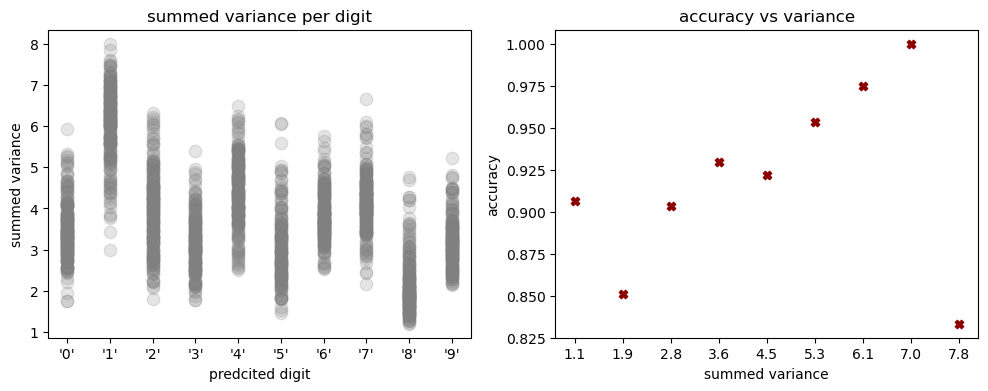

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter(mean_scores[:2000], var_scores[:2000], marker="o", color="grey", alpha=0.2, s=80)
plt.xticks(range(10), ["'"+str(i)+"'" for i in range(10)])
plt.xlabel("predcited digit")
plt.ylabel("summed variance")
plt.title("summed variance per digit")

plt.subplot(122)
plt.scatter(bins[:-1], accuracy, marker="X", color="darkred")
plt.xticks(bins[:-1], np.round(bins[:-1], 1))
plt.xlabel("summed variance")
plt.ylabel("accuracy")
plt.title("accuracy vs variance")

plt.show()

## Interpretability

In [14]:
from captum.attr import IntegratedGradients
from torch.distributions import Categorical

In [15]:
# the integrated gradients method works only with a single scalar as target 
# the following methods provide wrappers for some possible targets

def summed_variance_wrapper(sample):
    # run model and return summed variance
    mean, var = model.mean_var(sample)
    return var.sum(dim=1)

def entropy_wrapper(sample):
    # run model and return entropy of prediction
    probs = torch.nn.functional.softmax(model(sample), dim=1)
    return Categorical(probs = probs).entropy()

def variance_wrapper(sample):
    # run model and return variance vector
    mean, var = model.mean_var(sample)
    return var

In [16]:
IG_mean = IntegratedGradients(model) # init integrated gradient for predicted mean (requires to set target [0,9])
IG_var = IntegratedGradients(variance_wrapper) # init integrated gradient for predicted variance (requires to set target [0,9])

IG_svar = IntegratedGradients(summed_variance_wrapper) # init integrated gradient for summed variance
IG_ent = IntegratedGradients(entropy_wrapper) # init integrated gradient for entropy


## Visualize Explanations for mean, variance and entropy

In [17]:
# get new data sample
test_dl = DataLoader(test_set, 1, shuffle=True)
batch = next(iter(test_dl))
img, label = batch

DEVICE = "cpu"
model = model.to(DEVICE)

# calculate predictions  
predictions = model.sample(img, 100)
predictions = nn.functional.softmax(predictions, dim=1)
predictions = predictions.squeeze().detach().cpu().numpy()
vals, pos = torch.topk(torch.tensor(predictions), k=2, dim=0) # value and postion of the two predictions with highest probability

# calculate explanations:
n_steps = 50

# for digit with highest probability in most realizations
best = torch.mode(pos[0, :])[0] 
best_mean_attr = IG_mean.attribute(img, target = best, n_steps=n_steps)
# fordigit with second highest probability in most realizations
second_best = torch.mode(pos[1, :])[0] 
second_best_mean_attr = IG_mean.attribute(img, target = second_best, n_steps=n_steps)
#for entropy
ent_attr = IG_ent.attribute(img, n_steps=n_steps)
#for variance of most likely class
best_var_attr = IG_var.attribute(img, target = best, n_steps=n_steps)
#for variance of second most likely class
second_best_var_attr = IG_var.attribute(img, target = second_best, n_steps=n_steps)
#for summed variance
svar_attr = IG_svar.attribute(img, n_steps=n_steps)



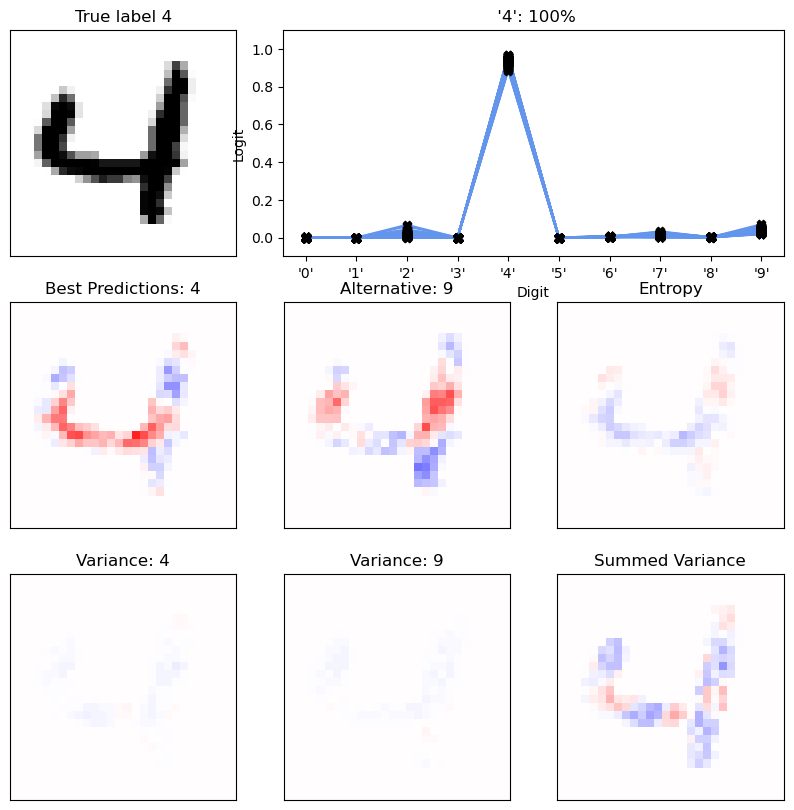

In [18]:
fig = plt.figure(figsize=(10,10))
gs = GridSpec(3, 3)

########################################################################################
# plot original input 
fig.add_subplot(gs[0, 0])
plt.imshow(img.squeeze(), cmap="binary")
plt.title(f"True label {label.item()}")
plt.xticks([])
plt.yticks([])

# plot stochastic prediction
fig.add_subplot(gs[0, 1:])
plt.plot(range(0,10), predictions, color="cornflowerblue", zorder=0)
for xe, ye in zip(range(0,10), predictions):
    plt.scatter([xe] * len(ye), ye, color="k", marker="X")
unique, counts = np.unique(np.argmax(predictions, axis=0), return_counts=True)
plt.title(' '.join(f" '{u}': {round(100*c/predictions.shape[1])}%" for u,c in zip(unique, counts)))
plt.xticks(range(0,10), ["'"+str(i)+"'" for i in range(10)])
plt.ylim(-0.1,1.1)
plt.xlabel("Digit")
plt.ylabel("Logit")

########################################################################################
# plot explanation of true class
fig.add_subplot(gs[1, 0])
plt.imshow(best_mean_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Best Predictions: {best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation of second most likely class
fig.add_subplot(gs[1, 1])
plt.imshow(second_best_mean_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Alternative: {second_best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation of total entropy
fig.add_subplot(gs[1,2])
plt.imshow(ent_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title("Entropy")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

########################################################################################
# plot explanation for variance of most likely class
fig.add_subplot(gs[2,0])
plt.imshow(best_var_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Variance: {best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation for variance of second most likely class
fig.add_subplot(gs[2,1])
plt.imshow(second_best_var_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Variance: {second_best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

#plot explanation for summed variance
fig.add_subplot(gs[2,2])
plt.imshow(svar_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title("Summed Variance")
plt.xticks([])
plt.yticks([])
#plt.colorbar()


plt.savefig("classification_and_explanation.png")
plt.show()

#### Visuialize only 'positive' attributions

In [19]:
IG_mean = IntegratedGradients(model) # init integrated gradient for predicted mean (requires to set target [0,9])

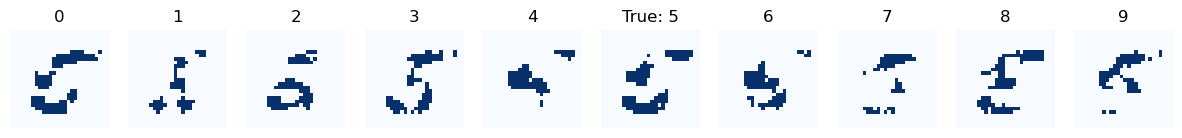

In [39]:
n_steps = 50

batch = next(iter(test_dl))
img, label = batch


pred_list = []
for i in range(10):
  pred_list.append(torch.nn.functional.relu(IG_mean.attribute(img, target = i, n_steps=n_steps).squeeze()))

plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(pred_list[i]>0, vmin=0, vmax=1, cmap="Blues")
    plt.axis("off")
    if i == label:
        plt.title("True: "+str(i))
    else:
        plt.title(i)


#### Visulatize contribution to true class and positive contributions to all other classes 

In [21]:
batch = next(iter(test_dl))
img, label = batch

In [40]:
explanation_other = torch.zeros(28, 28)

for i in range(10): 
    if i == label: 
        explanation_target = IG_mean.attribute(img, target = i, n_steps=n_steps).squeeze()
        explanation_summed_var = IG_svar.attribute(img, n_steps=n_steps).squeeze()
    else: 
        explanation_other += torch.nn.functional.relu(IG_mean.attribute(img, target = i, n_steps=n_steps).squeeze())

explanation_other /= 9

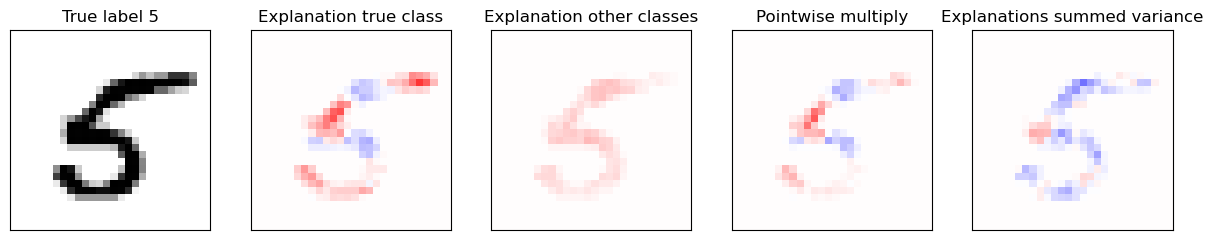

In [42]:
plt.figure(figsize=(15,3))

plt.subplot(151)
plt.imshow(img.squeeze(), cmap="binary")
plt.title(f"True label {label.item()}")
plt.xticks([])
plt.yticks([])

plt.subplot(152)
plt.imshow(explanation_target.squeeze(), cmap="seismic", vmin=-1, vmax=1)
plt.title("Explanation true class")
plt.xticks([])
plt.yticks([])

plt.subplot(153)
plt.imshow(explanation_other.squeeze(), cmap="seismic", vmin=-1, vmax=1)
plt.title("Explanation other classes")
plt.xticks([])
plt.yticks([])

plt.subplot(154)
plt.imshow(explanation_target.squeeze()*explanation_other.squeeze(), cmap="seismic", vmin=-0.1, vmax=0.1)
plt.title("Pointwise multiply")
plt.xticks([])
plt.yticks([])

plt.subplot(155)
plt.imshow(explanation_summed_var, cmap="seismic", vmin=-1, vmax=1)
plt.title("Explanations summed variance")
plt.xticks([])
plt.yticks([])


plt.show()

### Explanation of random image

In [24]:
img = torch.rand(1,28,28)

# calculate predictions  
predictions = model.sample(img, 100)
predictions = nn.functional.softmax(predictions, dim=1)
predictions = predictions.squeeze().detach().cpu().numpy()
vals, pos = torch.topk(torch.tensor(predictions), k=2, dim=0) # value and postion of the two predictions with highest probability

# calculate explanations:
n_steps = 50

# for digit with highest probability in most realizations
best = torch.mode(pos[0, :])[0] 
best_mean_attr = IG_mean.attribute(img, target = best, n_steps=n_steps)
# fordigit with second highest probability in most realizations
second_best = torch.mode(pos[1, :])[0] 
second_best_mean_attr = IG_mean.attribute(img, target = second_best, n_steps=n_steps)
#for entropy
ent_attr = IG_ent.attribute(img, n_steps=n_steps)
#for variance of most likely class
best_var_attr = IG_var.attribute(img, target = best, n_steps=n_steps)
#for variance of second most likely class
second_best_var_attr = IG_var.attribute(img, target = second_best, n_steps=n_steps)
#for summed variance
svar_attr = IG_svar.attribute(img, n_steps=n_steps)

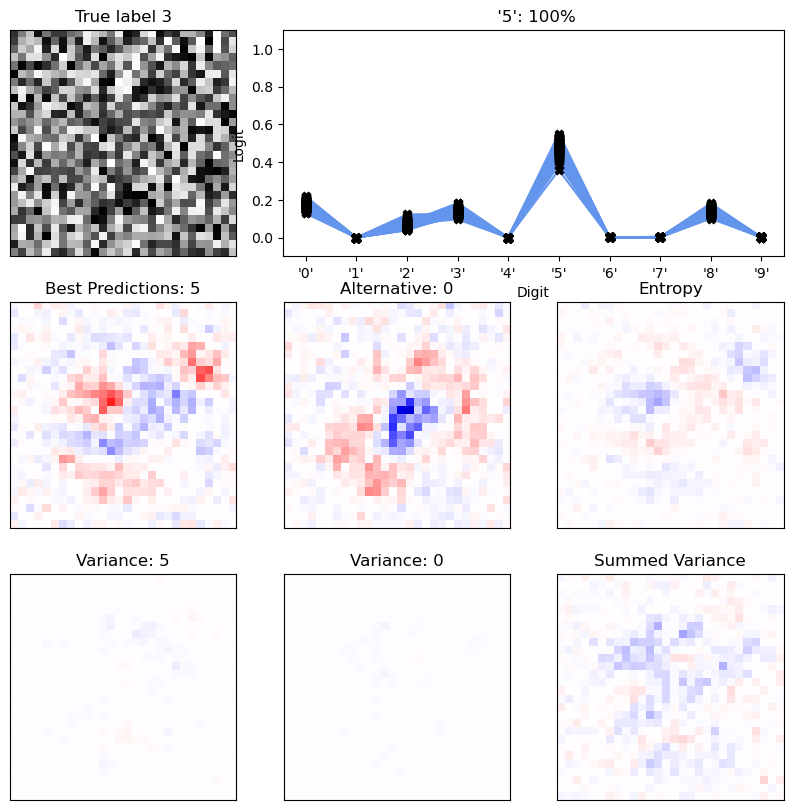

In [25]:
fig = plt.figure(figsize=(10,10))
gs = GridSpec(3, 3)

########################################################################################
# plot original input 
fig.add_subplot(gs[0, 0])
plt.imshow(img.squeeze(), cmap="binary")
plt.title(f"True label {label.item()}")
plt.xticks([])
plt.yticks([])

# plot stochastic prediction
fig.add_subplot(gs[0, 1:])
plt.plot(range(0,10), predictions, color="cornflowerblue", zorder=0)
for xe, ye in zip(range(0,10), predictions):
    plt.scatter([xe] * len(ye), ye, color="k", marker="X")
unique, counts = np.unique(np.argmax(predictions, axis=0), return_counts=True)
plt.title(' '.join(f" '{u}': {round(100*c/predictions.shape[1])}%" for u,c in zip(unique, counts)))
plt.xticks(range(0,10), ["'"+str(i)+"'" for i in range(10)])
plt.ylim(-0.1,1.1)
plt.xlabel("Digit")
plt.ylabel("Logit")

########################################################################################
# plot explanation of true class
fig.add_subplot(gs[1, 0])
plt.imshow(best_mean_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Best Predictions: {best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation of second most likely class
fig.add_subplot(gs[1, 1])
plt.imshow(second_best_mean_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Alternative: {second_best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation of total entropy
fig.add_subplot(gs[1,2])
plt.imshow(ent_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title("Entropy")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

########################################################################################
# plot explanation for variance of most likely class
fig.add_subplot(gs[2,0])
plt.imshow(best_var_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Variance: {best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation for variance of second most likely class
fig.add_subplot(gs[2,1])
plt.imshow(second_best_var_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Variance: {second_best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

#plot explanation for summed variance
fig.add_subplot(gs[2,2])
plt.imshow(svar_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title("Summed Variance")
plt.xticks([])
plt.yticks([])
#plt.colorbar()


plt.savefig("classification_and_explanation_RAND.png")
plt.show()

### Average of Digits

In [26]:
# average all imges of test set per digit
test_data = DataLoader(test_set, len(test_set), num_workers=4, pin_memory=True)
imgs, labels = next(iter(test_data))

AVGs = {}
for i in range(10):
  AVGs[i] = imgs[labels.squeeze()==i, :, :, :].mean(dim=0)

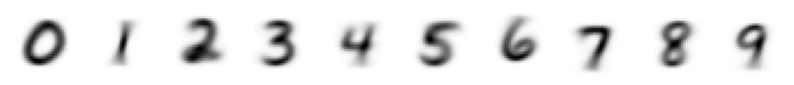

In [27]:
plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(1, 10,i+1)
    plt.imshow(AVGs[i].permute(1,2,0), cmap="Greys")
    plt.axis("off")

#### Explanation of average digit 

In [28]:
idx = 3
img = AVGs[idx]
label = torch.tensor(idx)

# calculate predictions  
predictions = model.sample(img, 100)
predictions = nn.functional.softmax(predictions, dim=1)
predictions = predictions.squeeze().detach().cpu().numpy()
vals, pos = torch.topk(torch.tensor(predictions), k=2, dim=0) # value and postion of the two predictions with highest probability

# calculate explanations:
n_steps = 50

# for digit with highest probability in most realizations
best = torch.mode(pos[0, :])[0] 
best_mean_attr = IG_mean.attribute(img, target = best, n_steps=n_steps)
# fordigit with second highest probability in most realizations
second_best = torch.mode(pos[1, :])[0] 
second_best_mean_attr = IG_mean.attribute(img, target = second_best, n_steps=n_steps)
#for entropy
ent_attr = IG_ent.attribute(img, n_steps=n_steps)
#for variance of most likely class
best_var_attr = IG_var.attribute(img, target = best, n_steps=n_steps)
#for variance of second most likely class
second_best_var_attr = IG_var.attribute(img, target = second_best, n_steps=n_steps)
#for summed variance
svar_attr = IG_svar.attribute(img, n_steps=n_steps)

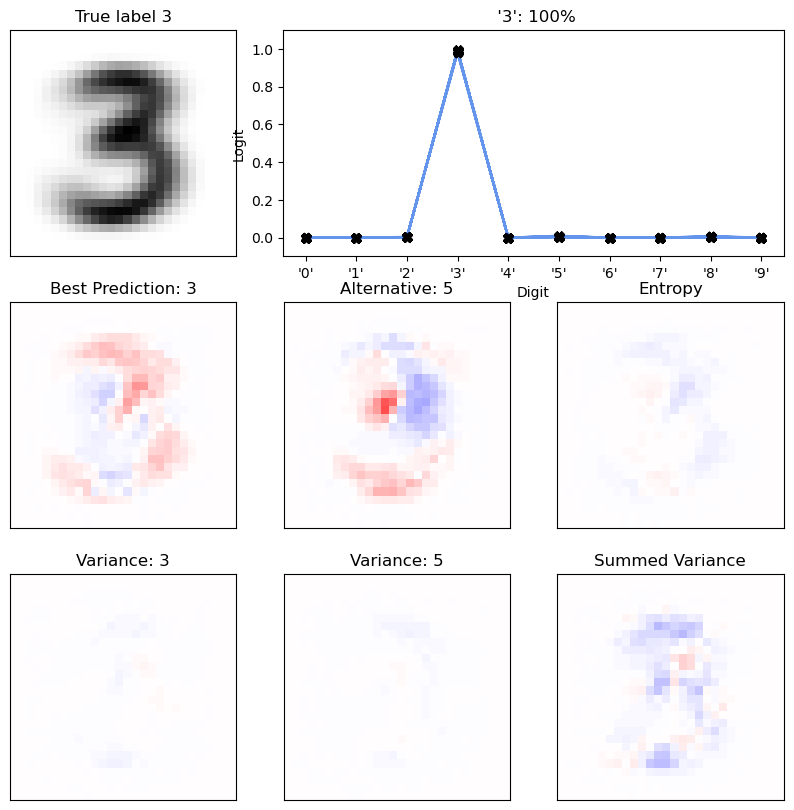

In [29]:
fig = plt.figure(figsize=(10,10))
gs = GridSpec(3, 3)

########################################################################################
# plot original input 
fig.add_subplot(gs[0, 0])
plt.imshow(img.squeeze(), cmap="binary")
plt.title(f"True label {label.item()}")
plt.xticks([])
plt.yticks([])

# plot stochastic prediction
fig.add_subplot(gs[0, 1:])
plt.plot(range(0,10), predictions, color="cornflowerblue", zorder=0)
for xe, ye in zip(range(0,10), predictions):
    plt.scatter([xe] * len(ye), ye, color="k", marker="X")
unique, counts = np.unique(np.argmax(predictions, axis=0), return_counts=True)
plt.title(' '.join(f" '{u}': {round(100*c/predictions.shape[1])}%" for u,c in zip(unique, counts)))
plt.xticks(range(0,10), ["'"+str(i)+"'" for i in range(10)])
plt.ylim(-0.1,1.1)
plt.xlabel("Digit")
plt.ylabel("Logit")

########################################################################################
# plot explanation of true class
fig.add_subplot(gs[1, 0])
plt.imshow(best_mean_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Best Prediction: {best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation of second most likely class
fig.add_subplot(gs[1, 1])
plt.imshow(second_best_mean_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Alternative: {second_best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation of total entropy
fig.add_subplot(gs[1,2])
plt.imshow(ent_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title("Entropy")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

########################################################################################
# plot explanation for variance of most likely class
fig.add_subplot(gs[2,0])
plt.imshow(best_var_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Variance: {best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

# plot explanation for variance of second most likely class
fig.add_subplot(gs[2,1])
plt.imshow(second_best_var_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title(f"Variance: {second_best.item()}")
plt.xticks([])
plt.yticks([])
#plt.colorbar()

#plot explanation for summed variance
fig.add_subplot(gs[2,2])
plt.imshow(svar_attr.squeeze(), vmin=-1, vmax=1, cmap="seismic")
plt.title("Summed Variance")
plt.xticks([])
plt.yticks([])
#plt.colorbar()


plt.savefig("classification_and_explanation_AVG.png")
plt.show()